# Load mat data exported from MATLAB

## My subheader

In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path, PurePath
from glob import glob
import scipy.io  as sio
import numpy as np
from pandas.core.frame import DataFrame
import pandas as pd
import warnings
from fooof import FOOOFGroup
from IPython.display import display
from matplotlib import pyplot as plt

In [2]:
def create_metadata_dict(path: str) -> dict:
    path_split = PurePath(path).parts
    subject = path_split[-2]
    filenamse = path_split[-1]
    condition = filename.split("_")[-1]
    condition = condition.split(".")[0]
    data_dict = {'subject':subject, 'filename':filename, 'condition': condition}
    return  data_dict 

def fooof2pandas(func):
    """Decorator for fooof function that will transform  foood output into datafram

    Args:
        func ([type]): [description]
    """
    def wrapper(*args, **kwargs):

        fg = func(*args, **kwargs)
        print('Number of model fits: ', len(fg))
        temp_df = pd.DataFrame() # prepare error and slope dataframe
        #temp_df['knee'] = fg.get_params('aperiodic_params', 'knee')
        temp_df['offset'] = fg.get_params('aperiodic_params', 'offset')
        temp_df['exponent'] = fg.get_params('aperiodic_params', 'exponent')

        temp_df['errors']= fg.get_params('error')
        temp_df['r2s']=fg.get_params('r_squared')
        temp_df.insert(0, 'ID', temp_df.index)
        
        peaks = fg.get_params('peak_params') # prepare peaks dataframe
        peaks_df = pd.DataFrame(peaks)
        peaks_df.columns = ['CF', 'PW', 'BW', 'ID']
        peaks_df['ID'] = peaks_df['ID'].astype(int)
        peaks_df = peaks_df.join(temp_df.set_index('ID'), on='ID')
        return peaks_df
    return wrapper


@fooof2pandas
def psd_fooof(freqs, spectra) -> DataFrame:
    """Use FOOOFGroup on data

    Args:
        freqs ([type]): vector with frequencies
        spectra ([type]): Matrix with ROIS x PSD values  #TODO check format

    Returns:
        DataFrame: Fooof values as outputed  in model
    """
    fg = FOOOFGroup(peak_width_limits=[2.5, 8],min_peak_height=0.05, max_n_peaks=6)
    fg.fit(freqs, spectra, freq_range=[3, 48],n_jobs=-1, progress='tqdm')
    return fg

def add_columns(peaks_df, row_names, data_dict) -> DataFrame :
    """Add metadata to fooof results

    Args:
        peaks_df (DataFrame): dataframe containing fooof results
        data_dict (DataFrame): dict containing metadata related to trial

    Returns:
        DataFrame: [description]
    """
    temp_df = pd.DataFrame() 
    temp_df["ROI"] = row_names
    temp_df.insert(0, 'ID', temp_df.index)
    temp_df["subjectID"] = data_dict["subject"]
    temp_df["condition"] = data_dict["condition"]
    peaks_df = peaks_df.join(temp_df.set_index('ID'), on='ID')
    return peaks_df

In [3]:
pandas_list = []
folder ='../data/lemon_rsEEG_dataset'
files = [Path(p) for p in glob(folder + "/*/*.mat")]

# Loop through files
with warnings.catch_warnings():
    # ignore warnings that come with older version of fooof
    warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
    for file in files:
        print(file)
        mat_content = sio.loadmat(file )
        data_dict=  create_metadata_dict(file)
        row_names = mat_content["RowNames"]
        row_names=  [l.flatten()[0] for l in row_names.flatten()] #flatten
        freqs = np.ndarray.squeeze(mat_content["Freqs"])
        tf = np.ndarray.squeeze(mat_content["TF"])
        #plot_spectra(freqs_data, powers_data, log_powers=True)
        peaks_df = psd_fooof(freqs, tf)
        peaks_df = add_columns(peaks_df, row_names, data_dict)
        pandas_list.append(peaks_df)

# list of dataframes to dataframe
df = pd.concat(pandas_list)
# Save temporary data
df.to_csv('../data/ROI_offset_exponent.csv', index = False, header=True)


../data/lemon_rsEEG_dataset/sub-032412/timefreq_psd_220208_0610_EC.mat


NameError: name 'filename' is not defined

In [ ]:
df.columns

Index(['CF', 'PW', 'BW', 'ID', 'offset', 'exponent', 'errors', 'r2s', 'ROI',
       'subjectID', 'condition'],
      dtype='object')

# Check the  data

In [ ]:
df = pd.read_csv('../data/ROI_offset_exponent.csv')

display(df.describe())
display(df.head())


,CF,PW,BW,ID,offset,exponent,errors,r2s
count,67940.000000,67940.000000,67940.000000,67940.000000,67940.000000,67940.000000,67940.000000,67940.000000
mean,18.592026,0.625792,5.977009,33.857624,-16.381240,1.659606,0.065979,0.975492
std,7.785852,0.357692,2.287220,19.641398,0.687632,0.510739,0.035162,0.032558
min,4.000000,0.000093,2.500000,0.000000,-19.513864,-0.910755,0.014448,0.346921
25%,10.754929,0.360803,3.374740,17.000000,-16.814861,1.391987,0.041946,0.972729
50%,18.711813,0.534550,7.590548,34.000000,-16.324548,1.741450,0.058378,0.983736
75%,24.244850,0.806061,8.000000,51.000000,-15.918882,2.020077,0.081270,0.989976
max,46.674990,2.432700,8.000000,67.000000,-13.743838,3.074425,0.433359,0.998094


,CF,PW,BW,ID,offset,exponent,errors,r2s,ROI,subjectID,condition
0,10.601997,0.995602,2.500000,0,-16.773654,1.590843,0.069819,0.977512,bankssts L,sub-032412,EC
1,20.394253,0.479953,8.000000,0,-16.773654,1.590843,0.069819,0.977512,bankssts L,sub-032412,EC
2,10.595415,0.944707,2.500000,1,-17.014893,1.382978,0.059309,0.980736,bankssts R,sub-032412,EC
3,20.448035,0.469201,6.091836,1,-17.014893,1.382978,0.059309,0.980736,bankssts R,sub-032412,EC
4,10.682303,0.502703,2.500000,2,-17.100722,1.791091,0.040982,0.991562,caudalanteriorcingulate L,sub-032412,EC


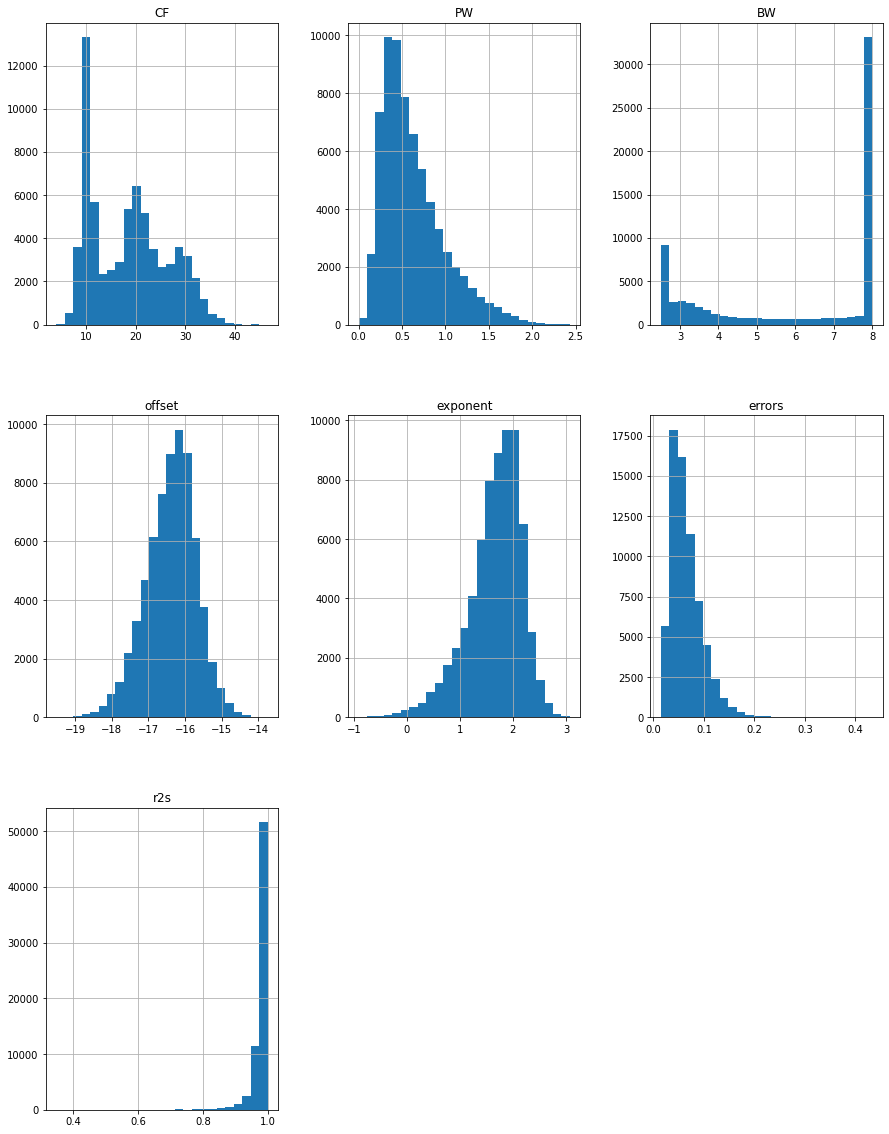

In [ ]:
df.hist( figsize = (15,20),column = ['CF', 'PW', 'BW', 'offset', 'exponent', 'errors', 'r2s', 'ROI', 'subjectID', 'condition'],  bins=25);

## Check the participants

,subjectID,gender,age
0,sub-032301,1,65-70
1,sub-032302,1,20-25
2,sub-032303,1,65-70
3,sub-032304,2,25-30
4,sub-032305,1,65-70
...,...,...,...
223,sub-032524,2,20-25
224,sub-032525,2,20-25
225,sub-032526,2,20-25
226,sub-032527,2,20-25


<AxesSubplot:>

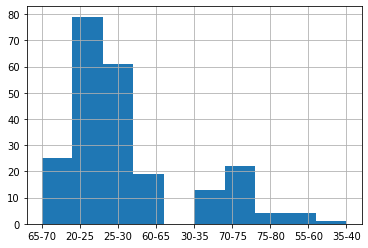

In [ ]:
participants = pd.read_csv('../data/Participants_LEMON.csv')
participants.columns = ['subjectID','gender','age']
display(participants)
participants["age"].hist()

<AxesSubplot:title={'center':'Count of number of participants in different age intervals'}>

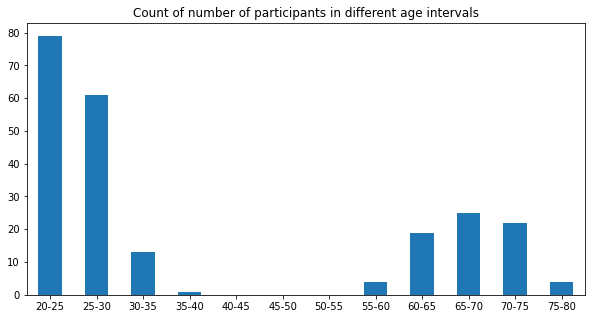

In [ ]:
raw_cat = pd.Categorical(
   ....:     participants["age"], categories=['20-25', '25-30', '30-35','35-40','40-45','45-50','50-55',
    '55-60','60-65','65-70', '70-75','75-80'], ordered=True
   ....: )
from matplotlib import pyplot as plt
plt.figure(figsize=(10, 5))
plt.title("Count of number of participants in different age intervals")
raw_cat.value_counts().plot.bar(rot=0)

In [ ]:
result = pd.merge(df,
                 participants[['subjectID','gender','age']],
                 on='subjectID')
result.head()

,CF,PW,BW,ID,offset,exponent,errors,r2s,ROI,subjectID,condition,gender,age
0,10.601997,0.995602,2.500000,0,-16.773654,1.590843,0.069819,0.977512,bankssts L,sub-032412,EC,2,20-25
1,20.394253,0.479953,8.000000,0,-16.773654,1.590843,0.069819,0.977512,bankssts L,sub-032412,EC,2,20-25
2,10.595415,0.944707,2.500000,1,-17.014893,1.382978,0.059309,0.980736,bankssts R,sub-032412,EC,2,20-25
3,20.448035,0.469201,6.091836,1,-17.014893,1.382978,0.059309,0.980736,bankssts R,sub-032412,EC,2,20-25
4,10.682303,0.502703,2.500000,2,-17.100722,1.791091,0.040982,0.991562,caudalanteriorcingulate L,sub-032412,EC,2,20-25


I am reordering here the order of columns 

In [ ]:
result  = result[['subjectID',
 'condition','CF','ROI',

 'offset',
 'exponent',
 'errors',
 'r2s',
  'PW',
 'BW',
 'gender',
 'age']]
result

,subjectID,condition,CF,ROI,offset,exponent,errors,r2s,PW,BW,gender,age
0,sub-032412,EC,10.601997,bankssts L,-16.773654,1.590843,0.069819,0.977512,0.995602,2.500000,2,20-25
1,sub-032412,EC,20.394253,bankssts L,-16.773654,1.590843,0.069819,0.977512,0.479953,8.000000,2,20-25
2,sub-032412,EC,10.595415,bankssts R,-17.014893,1.382978,0.059309,0.980736,0.944707,2.500000,2,20-25
3,sub-032412,EC,20.448035,bankssts R,-17.014893,1.382978,0.059309,0.980736,0.469201,6.091836,2,20-25
4,sub-032412,EC,10.682303,caudalanteriorcingulate L,-17.100722,1.791091,0.040982,0.991562,0.502703,2.500000,2,20-25
...,...,...,...,...,...,...,...,...,...,...,...,...
67935,sub-032469,EO,19.982836,temporalpole R,-16.738230,1.744570,0.062472,0.986519,0.598704,8.000000,2,20-25
67936,sub-032469,EO,9.914749,transversetemporal L,-16.789777,1.628003,0.070723,0.982766,1.218202,3.475544,2,20-25
67937,sub-032469,EO,20.017787,transversetemporal L,-16.789777,1.628003,0.070723,0.982766,0.695210,8.000000,2,20-25
67938,sub-032469,EO,9.916355,transversetemporal R,-16.879896,1.581279,0.067155,0.983885,1.231576,3.453974,2,20-25


In [ ]:
display(result["age"].unique())
x = {'20-25':'YOUNG', '25-30':'YOUNG', '30-35':'YOUNG','35-40':'YOUNG',
    '55-60':'OLD','60-65':'OLD','65-70':'OLD', '70-75':'OLD','75-80':'OLD', }
result['age_cond'] = result['age'].map(x)
csv_path =  '../data/all_ROI_offset_exponent_dataframe_merged.csv'

result.to_csv(csv_path, index = False, header=True)

array(['20-25', '60-65', '25-30', '70-75', '65-70', '55-60', '75-80',
       '30-35', '35-40'], dtype=object)